In [1]:
# pip install python-pptx
# pip install prophet
# pip install pandas
# pip install matplotlib
# pip install openpyxl
# pip install xgboost
# pip install scikit-learn


### **algoritmo:  XGBoost**
* **Incluye festivos Perú**
* **Incluye variables adicionales sobre máximos ocurridos en la mañana**
* **Incluye datos del cobre y predice estos valores**

In [1]:

import matplotlib as plt
import pandas as pd
import xgboost as xgb
from datetime import datetime, timedelta
from prophet import Prophet
import sklearn


/var/folders/tx/1tx9w9fj6v78n5f12zkwg_vc0000gn/T/ipykernel_32637/1026413862.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/jaimereinoso/DESARROLLO/CartonesAmericaProduccionXGBoostv3/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### **Paso 1:  bajar data**
ir a https://www.coes.org.pe/Portal/portalinformacion/demanda y bajar el ultimo año, colocando las fechas iniciales y finales y presionando el boton EXPORTAR.

El modelo va a asumir que hay datos hasta las 1:30 del ultimo dia del archivo.  Este vendrá posíblemente con más data o vacío de ahi en adelante, así que esas filas seran borradas

El archivo se lee desde el directorio source

In [3]:
# leemos el original
dfbase = pd.read_excel('DemandaCOES.xlsx',skiprows=3, header=0)
dfDiasFeriados = pd.read_excel('Festivos peru.xlsx')
# prophet solo funciona con estos nombres de columnas
dfbase = dfbase.rename(columns={'FECHA':'ds','EJECUTADO':'y'})
dfbase['ds'] = pd.to_datetime(dfbase['ds'], dayfirst=True)

### **Definiciones:**
* **dfbase:**  es la data original tomada desde la página de CAME con un año de historia y columnas **ds** y **y**
* **df:**      es una copia de dfbase asegurando 1 año de anticipación EXACTAMENTE y que tiene otras variables de lag e históricas.  Posteriormente a este dataframe se le adicionan todas las filas que falten para terminar el mes y en **y** se coloca el valor predicho
* **dfEsteMes:** solo tiene este mes de **df**, con la info tanto real como predicha
* **dfReal:**  es la parde de **dfEsteMes** que contiene sólo la real, y no incluye las predicciones
* **forecast:** es la prde de **dfEsteMes** que NO contiene la parte real, pero si las predicciones


In [4]:
# recortamos a solo FECHA y EJECUTADO, y dejamos solo los datos hasta el ultimo dia en el archivo - 1
# esto lo hacemos, porque en el archivo siempre viene las 12 de la noche del siguiente dia (00)

df = dfbase[['ds','y']].copy()

# vamos a eliminar toda fecha que sea superior a las 14:00 
# ultimaFecha es el dia de hoy

ultimaFila = df.iloc[-1]
ultimaFecha = ultimaFila['ds']
ultimaFecha = ultimaFecha.strftime('%Y-%m-%d') + ' ' + '14:00:00'
ultimaFecha = pd.to_datetime(ultimaFecha)
ultimaFecha = ultimaFecha - timedelta(days=1)  # quitamos un dia porque el archivo siempre trae la primera media hora del dia siguiente


# OJO, A MENOS QUE SEAN PRUEBAS, MANTENER ESTO CON COMENTARIOS
# vamos a probar si puede predecir bien diciembre 2023
# fecha_limite = pd.to_datetime("2023-01-15 14:00:00")
# df = df[df['ds'] <= fecha_limite]
# ultimaFecha = fecha_limite


print('ultimaFecha:', ultimaFecha)

ultimaFecha: 2024-02-06 14:00:00


### **Paso 2:  entrenar XGBOOST con df**

In [5]:
def crea_features(dfInput):

    # crea el Yi-1, Yi-2, ....
    lista_lags = []
    for i in range(1,30*48):
        new_df = pd.DataFrame()
        new_df['lag_' + str(i)] = dfInput['y'].shift(i)
        lista_lags.append(new_df)

    df_lg = pd.concat(lista_lags, axis=1)

    # promedios rodantes por dia (48 medias horas)
    # crea el  promedio de Yi-1, Yi-2, Yi-3 ... Yi-48 como rolling_day_1
    #                      Yi-2, Yi-3, Yi-4 .... Yi-48 como rolling_day_2
    # rolling_day_1 .. roling_day_30

    lista_rolling = []
    for i in range(1,31):
        new_df = pd.DataFrame()
        new_df['rolling_day_' + str(i)] = dfInput['y'].shift(i).rolling(window=48).mean()  # colocar 48
        lista_rolling.append(new_df)

    df_r = pd.concat(lista_rolling, axis=1)

    # promedios rodantes de la semana (48*7), ultimas 25 semanas
    # rolling_week_1 .. rolling_week_24
    lista_rolling_week = []
    for i in range(1,25):
        new_df = pd.DataFrame()
        new_df['rolling_week_' + str(i)] = dfInput['y'].shift(i).rolling(window=48*7).mean()
        lista_rolling_week.append(new_df)

    df_w = pd.concat(lista_rolling_week, axis=1)

    # # ahora la media del mes (48*30), ultimos 12 meses
    # rolling_month_1 .. rolling_month_12

    lista_rolling_month = []
    for i in range(1,13):
        new_df = pd.DataFrame()
        new_df['rolling_month_' + str(i)] = dfInput['y'].shift(i).rolling(window=48*30).mean()
        lista_rolling_month.append(new_df)

    df_m = pd.concat(lista_rolling_month, axis=1)


    # -------

    df_n = pd.concat([df_lg, df_r, df_w, df_m], axis=1)

    return df_n

In [6]:
df_features = crea_features(df)
df = pd.concat([df, df_features], axis=1)
df = df.dropna()
df = df.reset_index(drop=True)

In [7]:
import xgboost as xgb

f = ultimaFecha
# df es nuevamente creado con 1 año hacia atras de datos hasta el mes en que vamos
df = df[(df['ds'] > f - pd.DateOffset(years=1)) &
        (df['ds'] <= f)].copy()

df = df.reset_index(drop=True)

# Entrenar el modelo XGBoost
params = {
    'objective': 'reg:squarederror',  # Para problemas de regresión
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
}
model = xgb.XGBRegressor(**params)

X_train = df.drop(['y', 'ds'], axis=1)
y_train = df['y']  # estos son valores reales

model.fit(X_train, y_train)

# Extraer el mes actual
ano_actual = f.year
mes_actual = f.month

if mes_actual == 12:
    siguiente_ano = ano_actual + 1
    siguiente_mes = 1
else:
    siguiente_ano = ano_actual
    siguiente_mes = mes_actual + 1

# el primer horario del mes es a las 0:30pm
primer_dia_mes_actual = datetime(ano_actual, mes_actual, 1, 0, 30, 0)

# y hay que predecir hasta el primer media hora del siguiente mes
primer_dia_siguiente_mes = datetime(siguiente_ano, siguiente_mes, 1, 0, 0, 0)

f_prediccion = f 

### **Paso 3:  generamos predicción del resto del mes**

In [8]:
while f_prediccion <= primer_dia_siguiente_mes:

    print('          ',f_prediccion)

    nueva_fila = []

    # adicionamos el nuevo ds
    nueva_fila.append( f_prediccion)

    # adicionamos el nuevo y (y_predicho que se calcula
    nuevo_y = 0 #model.predict(X_test)
    nueva_fila.append(nuevo_y)

    # ---------  FILAS LAGS_i  ---------------
    # creamos todos los demas lags.  El primero le copiamos "y" anterior
    filaLags = df.iloc[-1]['lag_1':'lag_1439'].copy()
    filaLags = filaLags.shift(1)
    filaLags = filaLags.tolist()
    filaLags[0]=df.iloc[-1]['y']

    # ---------  FILAS ROLLING_DAY_i 1:30 ---------------
    # promedios rodantes del dia (48 medias horas), un dia

    # se hace shift y la primera se calcula con la media de las ultimas 48 medias horas = 1 dia
    columnas_seleccionadas = [col for col in df.columns if col.startswith('rolling_day_')]

    # se hace shift y la primera se calcula con la media de las ultimas 24 y
    filaRDays = df.iloc[-1][columnas_seleccionadas].copy()
    filaRDays = filaRDays.shift(1)
    filaRDays = filaRDays.tolist()
    filaRDays[0]=df['y'].tail(48).mean() 

    # ---------  FILAS ROLLING_WEEK_i  ---------------
    # promedios rodantes de la semana (48 medias horas * 7 dias), 

    columnas_seleccionadas = [col for col in df.columns if col.startswith('rolling_week_')]

    # se hace shift y la primera se calcula con la media de las ultimas 24 y
    filaRWeeks = df.iloc[-1][columnas_seleccionadas].copy()
    filaRWeeks = filaRWeeks.shift(1)
    filaRWeeks = filaRWeeks.tolist()
    filaRWeeks[0]=df['y'].tail(48*7).mean() 

    # ---------  FILAS ROLLING_MONTH_i  ---------------
    # promedios rodantes de la semana (48 medias horas * 30 dias),      

    columnas_seleccionadas = [col for col in df.columns if col.startswith('rolling_month_')]

    # se hace shift y la primera se calcula con la media de las ultimas 24 y
    filaRMonths = df.iloc[-1][columnas_seleccionadas].copy()
    filaRMonths = filaRMonths.shift(1)
    filaRMonths = filaRMonths.tolist()
    filaRMonths[0]=df['y'].tail(48*30).mean() 

    # ---------  END  -------------------------------

    # esta es la nueva fila que vamos a predecir 
    nueva_fila = nueva_fila + filaLags + filaRDays + filaRWeeks + filaRMonths 

    #  insertamos la nueva fila en el dataframe
    df.loc[len(df)] = nueva_fila

    # tomamos la ultima fila, ahora si como un dataframe
    dfTest = df.tail(1).copy()

    # # generamos la nueva predicción creando la fila que vamos a predecir
    X_test = dfTest.drop(columns=['y', 'ds'])

    nuevo_y = model.predict(X_test)

    # Asignamos el valor obtenido a la columna "y" de la última fila de df
    df.at[df.index[-1], 'y'] = nuevo_y[0]

    # Nos movemos 30 minutos más adelante
    f_prediccion = f_prediccion + pd.DateOffset(minutes=30)

           2024-02-06 14:00:00
           2024-02-06 14:30:00
           2024-02-06 15:00:00
           2024-02-06 15:30:00
           2024-02-06 16:00:00
           2024-02-06 16:30:00
           2024-02-06 17:00:00
           2024-02-06 17:30:00
           2024-02-06 18:00:00
           2024-02-06 18:30:00
           2024-02-06 19:00:00
           2024-02-06 19:30:00
           2024-02-06 20:00:00
           2024-02-06 20:30:00
           2024-02-06 21:00:00
           2024-02-06 21:30:00
           2024-02-06 22:00:00
           2024-02-06 22:30:00
           2024-02-06 23:00:00
           2024-02-06 23:30:00
           2024-02-07 00:00:00
           2024-02-07 00:30:00
           2024-02-07 01:00:00
           2024-02-07 01:30:00
           2024-02-07 02:00:00
           2024-02-07 02:30:00
           2024-02-07 03:00:00
           2024-02-07 03:30:00
           2024-02-07 04:00:00
           2024-02-07 04:30:00
           2024-02-07 05:00:00
           2024-02-07 05:30:00
        

### **Paso 4:  mostrar resultados**

### **Definiciones:**
* **dfbase:**  es la data original tomada desde la página de CAME con un año de historia y columnas **ds** y **y**
* **df:**      es una copia de dfbase asegurando 1 año de anticipación EXACTAMENTE y que tiene otras variables de lag e históricas.  Posteriormente a este dataframe se le adicionan todas las filas que falten para terminar el mes y en **y** se coloca el valor predicho
* **dfEsteMes:** solo tiene este mes de **df**, con la info tanto real como predicha
* **dfReal:**  es la parde de **dfEsteMes** que contiene sólo la real, y no incluye las predicciones
* **forecast:** es la prde de **dfEsteMes** que NO contiene la parte real, pero si las predicciones

## ALERTA: los dataframes luego deben ser recortados cuando corresponda para que solo tomen los datos entre las 5y 11pm de Lunes a Sábado.

In [18]:
# creamos los dataframes con los datos completos del mes (dfEsteMes), solo lo real (dfReal) o solo lo predicho (forecast)
# OJO, en este punto tiene los datos de todas las horas y no solo de 5 a 11pm de L a S.

dfEsteMes = df[(df['ds'] <= primer_dia_siguiente_mes) & 
              (df['ds'] >= primer_dia_mes_actual)].copy()

# OJO, la fila con hora 17:30, mide lo consumido entre las 5:00pm y las 5:30pm.   
dfEsteMesRango = dfEsteMes[(dfEsteMes['ds'].dt.weekday < 6) &
                        (dfEsteMes['ds'].dt.time >= pd.to_datetime('17:30').time()) & 
                        (dfEsteMes['ds'].dt.time < pd.to_datetime('23:30').time())
                           ]

dfReal = df[(df['ds'] < primer_dia_siguiente_mes) & 
               (df['ds'] >= primer_dia_mes_actual)].copy()

dfRealRango = dfReal[(dfReal['ds'].dt.weekday < 6) & 
                     (dfReal['ds'].dt.time >= pd.to_datetime('17:30').time()) & 
                     (dfReal['ds'].dt.time < pd.to_datetime('23:30').time())]

forecast = df[(df['ds'] <= primer_dia_siguiente_mes) & 
              (df['ds'] >= f)].copy()

forecastRango = forecast[(forecast['ds'].dt.weekday < 6) &
                         (forecast['ds'].dt.time >= pd.to_datetime('17:30').time()) & 
                         (forecast['ds'].dt.time < pd.to_datetime('23:30').time())]


pico_predicho_idx = dfEsteMesRango['y'].idxmax()
pico_predicho_y = dfEsteMesRango['y'].max()
pico_predicho_ds = dfEsteMesRango.loc[pico_predicho_idx,'ds'] 
pico_predicho_yyyymmdd = pico_predicho_ds.strftime('%Y-%m-%d')

In [19]:
print(pico_predicho_y, pico_predicho_ds)

7807.78804 2024-02-05 19:30:00


In [20]:
# determinamos el pico maximo a tolerar, y se lee de forecastRango, o sea de los dias que faltan, 
# y solo tomando en cuenta el horario entre las 5 y 11pm, de lunes a sábado

c = 0.005
pico_corte = pico_predicho_y*(1-c)
dfDiasAEliminar = forecastRango[forecastRango['y']>pico_corte].copy()

dfDiasAEliminar['fecha'] = dfDiasAEliminar['ds'].dt.strftime('%Y-%m-%d')
dfDiasAEliminarFinal = dfDiasAEliminar['fecha'].drop_duplicates()
dfDiasAEliminarFinal = dfDiasAEliminarFinal[dfDiasAEliminarFinal>=ultimaFecha.strftime('%Y-%m-%d')]

In [21]:
forecastRango.to_excel('forecastRango.xlsx')
dfDiasAEliminarFinal.to_excel('dfDiasAEliminarFinal.xlsx')

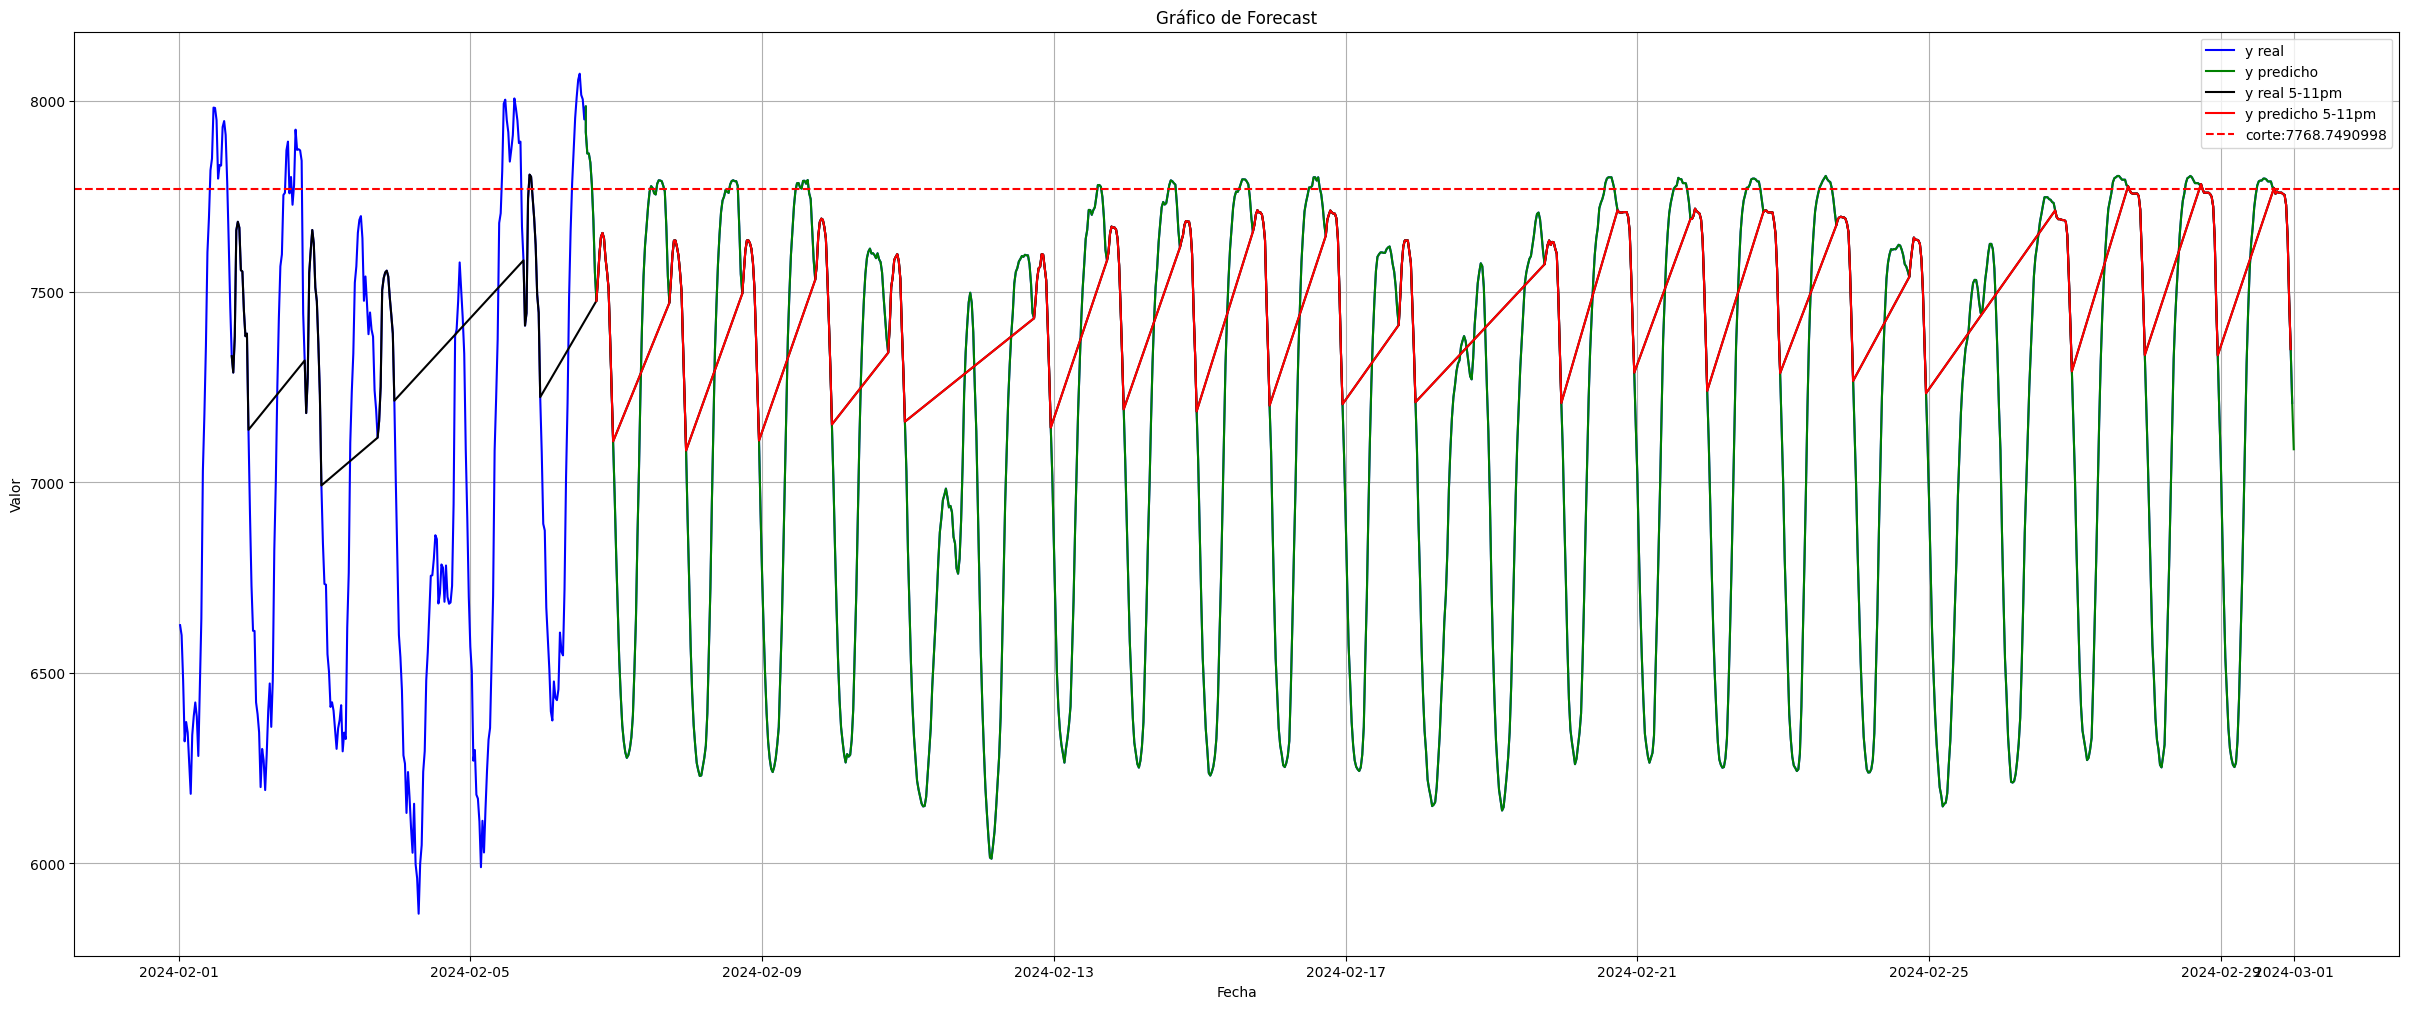

18535    2024-02-27
18583    2024-02-28
18631    2024-02-29
Name: fecha, dtype: object


In [22]:
import matplotlib.pyplot as plt

# Crea el gráfico
plt.figure(figsize=(30, 12))  # Tamaño del gráfico
# Grafica la columna "ds" en el eje x, "y" en el eje y (línea azul) 
plt.plot(dfReal['ds'], dfReal['y'], label='y real', color='blue')
plt.plot(forecast['ds'], forecast['y'], label='y predicho', color='green')
plt.plot(dfRealRango['ds'], dfRealRango['y'], label='y real 5-11pm', color='black')
plt.plot(forecastRango['ds'], forecastRango['y'], label='y predicho 5-11pm', color='red')
# Agrega la línea horizontal en la altura de "pico_corte"
plt.axhline(y=pico_corte, color='red', linestyle='--', label=f'corte:{pico_corte}')

# Personaliza el gráfico
plt.title('Gráfico de Forecast')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()  # Muestra la leyenda

# Muestra el gráfico
plt.grid(True)

# Guarda la imagen generada por Matplotlib en un archivo temporal
temp_img_path = 'temp_plot.png'
plt.savefig(temp_img_path)
plt.show()

print(dfDiasAEliminarFinal)

Abrir el archivo "Reportar Resultados.ppt" y reemplazar la gráfica y la lista de dias y enviar a Cartones América

Ahora vamos a obter el máximo por dia

In [23]:
# Obtenemos los picos por dia, tomando en cuenta solo rango
max_values_per_day_rango = dfEsteMesRango.groupby(dfEsteMesRango['ds'].dt.date)['y'].max().reset_index()
max_values_per_day_rango['ds'] = pd.to_datetime(max_values_per_day_rango['ds'], dayfirst=True)

# pico_predicho_y y pico_predicho_ds tienen el valor máximo del mes en horario 5-11pm de L a S.


import matplotlib.pyplot as plt


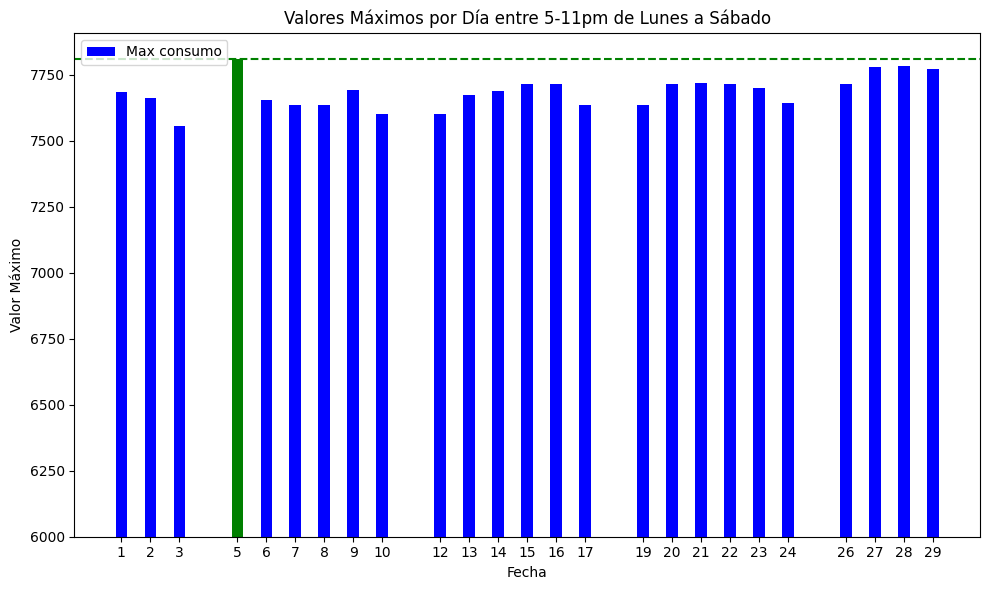

In [24]:
# Crear una gráfica de barras
plt.figure(figsize=(10, 6))  # Establecer el tamaño de la gráfica

# Obtener las fechas (días) y los valores máximos de  'Y'
fechas = max_values_per_day_rango['ds']
max_y = max_values_per_day_rango['y']

# # Obtener el día del mes
fechas = pd.to_datetime(fechas)
dias_mes = fechas.dt.day
dia_max = pico_predicho_ds.day


# Configurar las barras de y
colores_barras = ['blue' if dia != dia_max else 'green' for dia in dias_mes]

plt.bar(dias_mes, max_y, width=0.4, label='Max consumo', align='center', color=colores_barras)
#Configurar el límite inferior del eje Y para que arranque desde 6,000
plt.ylim(6000, max(max_y ) + 100)  # Ajusta el límite superior según tus datos


# Configurar el eje x para que muestre las fechas de forma legible
plt.xticks(dias_mes)
plt.xlabel('Fecha')

# Etiquetas y leyenda
plt.ylabel('Valor Máximo')
plt.legend(loc='upper left')

# Título de la gráfica
plt.title('Valores Máximos por Día entre 5-11pm de Lunes a Sábado')


# Destacar el valor máximo global de 'YHAT' con otro color
plt.axhline(y=pico_predicho_y, color='green', linestyle='--', label=f'Max Global YHAT ({pico_predicho_y:.2f})')

# Mostrar la gráfica
plt.tight_layout()

# Guarda la imagen generada por Matplotlib en un archivo temporal
temp_img_path2 = 'temp_plot2.png'
plt.savefig(temp_img_path2)
plt.show()




# Generamos POWERPOINT

In [25]:
from pptx import Presentation
from pptx.util import Inches
from pptx.dml.color import RGBColor

# Cargar la presentación
prs = Presentation('Reportar Resultados Template.pptx')

# Seleccionar la diapositiva deseada (por ejemplo, la primera diapositiva)
slide = prs.slides[1]

# Recorrer todas las imágenes en la diapositiva
# for i, shape in enumerate(slide.shapes):
#     print(i, '-' , shape.name, '-', shape.shape_type)

# 0, 6 y 11 son imagenes.  el 9 es un grafico
# 0:  calendario
# 6:  icono de cartones america
# 9:  la x blanca en un circulo rojo
# 11: es la gráfica que queremos actualizar!! y es de tipo PICTURE 13

newImagePath = 'temp_plot.png'
slide.shapes.add_picture(newImagePath, Inches(0), Inches(2.37), Inches(7.24), Inches(3))

dfDiasAEliminarFinal = dfDiasAEliminarFinal.reset_index(drop=True)

table = slide.shapes.add_table(rows=dfDiasAEliminarFinal.size+1, cols=2, left=Inches(7.72), top=Inches(2.39), width=Inches(5), height=Inches(0.8)).table

# Agregar contenido a la tabla (opcional)
# Puedes acceder a las celdas de la tabla y agregar contenido a cada celda
table.cell(0, 0).text = "id"
table.cell(0, 1).text = "Día"

i = 1
for dia in dfDiasAEliminarFinal:
    table.cell(i, 0).text = str(i)
    table.cell(i, 1).text = dia
    i += 1

# Seleccionar la diapositiva tercera
slide = prs.slides[2]
newImagePath = 'temp_plot2.png'
slide.shapes.add_picture(newImagePath, Inches(0), Inches(2.37), Inches(7.24), Inches(3))

text_box = slide.shapes.add_textbox(Inches(7.72), Inches(2.39), Inches(5), Inches(0.8))

# Agrega un párrafo de texto al cuadro de texto
tf = text_box.text_frame
p = tf.add_paragraph()
p.text = pico_predicho_yyyymmdd

# Ajusta el formato del texto
p.font.size = Inches(0.5)
p.font.bold = True
color = RGBColor(0, 128, 0)  # Rojo (255, 0, 0) en formato RGB
p.font.color.rgb = color

prs.save('Reportar Resultados.pptx')


In [26]:
dfDiasAEliminarFinal

0    2024-02-27
1    2024-02-28
2    2024-02-29
Name: fecha, dtype: object